## Zeek/Bro Security Monitor

Zeek (formerly Bro) is an open source Network Analysis and Security Monitoring tool.  It is able to collect details about the connections hosts are making within the network, in a similar way to NetFlow.  Unlike NetFlow, Zeek contains additional data which for the purpose of this analysis simplifies it.

Datasets were gathered from from the [2012 Mid-Atlantic Collegiate Cyber Defense Competition](https://www.netresec.com/?page=MACCDC) and consist of Zeek's conn.log file.  

## Notebook Scope
This Notebook represents a proof-of-concept and explorative piece to understand the concepts behind the Producer/Consumer Ratio threat hunting technique. 

In [34]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The Data

For the exploration, data was gathered from the [2012 Mid-Atlantic Collegiate Cyber Defense Competition](https://www.netresec.com/?page=MACCDC) and consist of Zeek's conn.log file.  These files were stored within the directory of /datasets/ID/ where ID represents a detection time bucket. 

### Conn.log Schema
| Field          | Desc                                                 | Type     | 
|----------------|------------------------------------------------------|----------|
| ts             | Timestamp of connection                              | datetime |
| uid            | Unique ID of connection                              | string   |
| id.orig_h      | Originating connection's host IP address             | string   |
| id.orig_p      | Originating connection's host port number            | integer  |
| id.resp_h      | Responding connection's host IP address              | string   |
| id.resp_p      | Responding connection's host port number             | integer  |
| proto          | Transport layer protocol of connection               | string   |
| service        | Dynamically detected application protocol, if any    | string   |
| duration       | Length of time of the connection                     | float    |
| orig_bytes     | Originators payload bytes                            | integer  |
| resp_bytes     | Responder payload bytes                              | integer  |
| conn_state     | Connection state                                     | string   |
| local_orig     | If conn originated locally; T, if remotely F         | boolean  |
| missed_bytes   | Number of missi9ng bytes in content gaps             | integer  |
| history        | Connection state history                             | string   |
| orig_pkts      | Number of orig packets                               | integer  |
| orig_ip_bytes  | Number of Orig IP bytes                              | integer  |
| resp_pkts      | Number of responding packets                         | integer  |
| resp_ip_bytes  | Number of Resp IP bytes                              | integer  |
| tunnel_parents | If tunneled, connection UID of encapsulating parents | string   |



In [70]:
def parseBro(file):
    """This function converts a given conn.log into a Pandas DataFrame. 
    """
    
    df = pd.read_csv(file, delimiter='\t', skiprows=[0,1,2,3,4,5,6], skipfooter=1, engine='python')
     
    df.columns = ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','service','duration','orig_bytes','resp_bytes','conn_state',
                  'local_orig','missed_bytes','history','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents', 'delete']
    
    # Typecast the 'ts' column to be a datetime.
    df['ts'] = pd.to_datetime(df['ts'],unit='s')
    
    return df

def generateDF(files):
    """This function generates a single DataFrame from a collection of conn.logs
    """
    
    # Initialise an empty DataFrame.
    df = pd.DataFrame()
    
    for file in files:
        df = pd.concat([df, parseBro('./datasets/a/' + str(file) + str('/conn.log'))])
        
    return df

fileList = os.listdir(path='./datasets/a/')[1:10]
df = generateDF(fileList)
df = df.loc[df['service'] == 'dns']
df.head()

## Calculating PCR Value

In [64]:
df = df.groupby('id.orig_h').sum()

df['PCR'] = (df['orig_ip_bytes'] - df['resp_ip_bytes'])/(df['orig_ip_bytes'] + df['resp_ip_bytes'])

df.head()

,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,delete,PCR
id.orig_h,,,,,,,,,
192.168.1.10,20996,1060,0,86,5777,86,11720,0.0,-0.339658
192.168.10.10,34193,1696,0,218,13908,217,28425,0.0,-0.342924
192.168.100.10,74449,3710,0,213,13872,205,25392,0.0,-0.293399
192.168.101.10,38582,1961,0,141,9102,126,13967,0.0,-0.210889
192.168.102.10,29046,1484,0,149,9540,149,19689,0.0,-0.347224


## Plotting Timeseries
Plots the timeseries vs PCR values to visually inspect for trends.

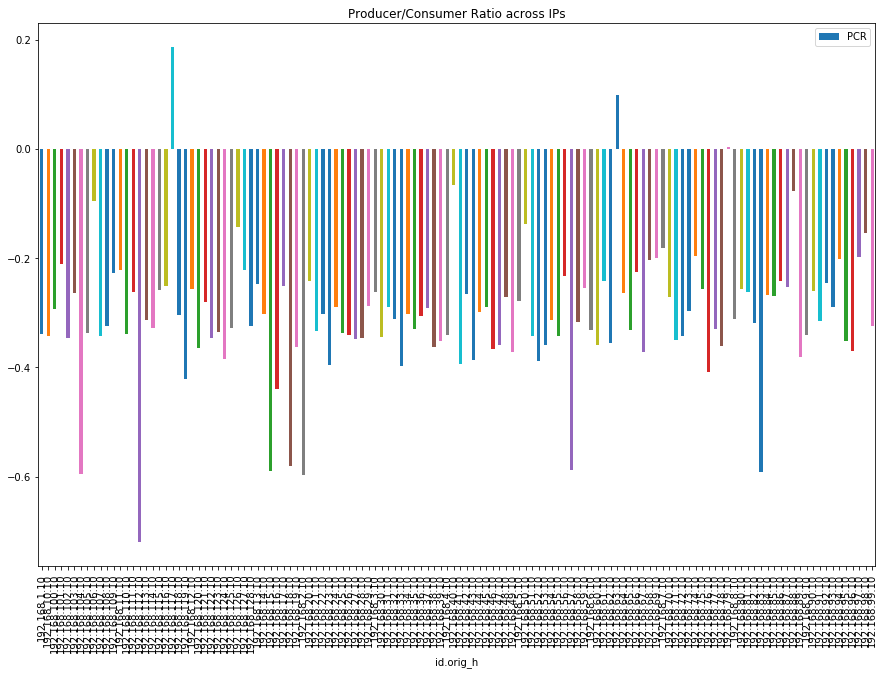

In [65]:
df.plot.bar(y='PCR', figsize=(15,10), title="Producer/Consumer Ratio across IPs")